In [10]:
from scipy.linalg import block_diag
from scipy.io import loadmat
import autograd.numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ssm

%matplotlib inline

This notebook contains much of my launching off into learning more about state space models. After fitting the models, I look at some basic descriptive statistics of the predictions made by the models, as well as a residual analysis, where I try to find where the models had less goodness-of-fit. I also journal more jumping off points and things to investigate closer to the end of the notebook.

In [11]:
import scipy.io as spio


def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [12]:
num_states = 30
obs_dim = 137

In [13]:
DATA_PATH = '../data/'
binnedPRE = loadmat(DATA_PATH + 'binnedPBEs_PRE.mat')['binnedPBEs_PRE']
binnedRUN = loadmat(DATA_PATH + 'binnedPBEs_RUN.mat')['binnedPBEs_RUN']
binnedPOST = loadmat(DATA_PATH + 'binnedPBEs_POST.mat')['binnedPBEs_POST']

In [8]:
proc_PRE = np.concatenate([x[1].T.astype(np.int8) for x in binnedPRE]).astype(int)

In [9]:
proc_PRE.shape

(51560, 137)

In [5]:
BDseqscore = loadmat(DATA_PATH + 'BayesianReplayDetection.mat')['BDseqscore']

prctilePOST = np.array(BDseqscore['POST']['data']['wPBEtimeswap']['weightedCorr']['prctilescore'])
prctilePRE = np.array(BDseqscore['PRE']['data']['wPBEtimeswap']['weightedCorr']['prctilescore'])
prctileRUN = np.array(BDseqscore['RUN']['data']['wPBEtimeswap']['weightedCorr']['prctilescore'])
del BDseqscore

### Choice on quality of data

Here we choose a threshold of 95 - we are only keeping the top 5% of events (those events that have the most clear structure)

In [6]:
lb = 95
ub = 100

restrictedDataPOST = binnedPOST[np.where(prctilePOST > lb),:]
restrictedDataPRE = binnedPRE[np.where(prctilePRE > lb),:]
restrictedDataRUN = binnedRUN[np.where(prctileRUN > lb),:]

restrictedEvents = np.concatenate((restrictedDataPRE,
                restrictedDataRUN,
                restrictedDataPOST), axis = 1).squeeze()

In [17]:
n_events = restrictedEvents.shape[0]
train_frac = 0.75
n_train = int(0.75*n_events)

indices = np.random.permutation(n_events)
training_idx, test_idx = indices[:n_train], indices[n_train:]
training, test = restrictedEvents[training_idx,:], restrictedEvents[test_idx,:]

y_train = np.concatenate([x[1].T.astype(np.int8) for x in training]).astype(int)
y_test = np.concatenate([x[1].T.astype(np.int8) for x in test]).astype(int)

N = obs_dim
K = 5
D = 2

NameError: name 'restrictedEvents' is not defined

In [20]:
binnedPRE_1ms = np.concatenate([x[1].T.astype(np.int8) for x in binnedPRE]).astype(int)
binnedRUN_1ms = np.concatenate([x[1].T.astype(np.int8) for x in binnedRUN]).astype(int)
binnedPOST_1ms = np.concatenate([x[1].T.astype(np.int8) for x in binnedPOST]).astype(int)

N = binnedPRE_1ms.shape[1]
K = 5
D = 2
iters = 1

In [29]:
PBEs = {
    'PRE': binnedPRE_1ms,
    'RUN': binnedRUN_1ms,
    'POST': binnedPOST_1ms
}

training = [
    {
        'in': ['PRE'],
        'out': ['RUN', 'POST'],
    },
    {
        'in': ['RUN'],
        'out': ['PRE', 'POST'],
    },
    {
        'in': ['POST'],
        'out': ['PRE', 'RUN'],
    },
    {
        'in': ['PRE','POST'],
        'out': ['RUN'],
    }

]

for train in training:
    ### training

    y_train = np.concatenate([PBEs[x] for x in train['in']], axis = 0)
    slds = ssm.SLDS(N, K, D, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))
    slds.initialize(y_train)

    q_elbos, q = slds.fit(y_train, method="laplace_em",
                                variational_posterior="structured_meanfield",
                                num_iters=iters, initialize=False, alpha=0)
    ### testing
    y_test = np.concatenate([PBEs[x] for x in train['out']], axis = 0)
    elbos_test, posterior_test = slds.approximate_posterior(y_test,
                                            method="laplace_em",
                                            variational_posterior="structured_meanfield",
                                            num_iters=iters)

    ### write to file

    tr = ','.join(train['in'])
    te = ','.join(train['out'])
    MODEL_OBJECT = f'K{K}_D{D}_train{tr}_test{te}.pkl'
    pickle.dump([q_elbos, q, slds, elbos_test, posterior_test], open(RESULTS_PATH + '/' + MODEL_OBJECT, 'wb'))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

NameError: name 'pickle' is not defined

In [28]:
np.concatenate([PBEs[x] for x in train['out']], axis = 0).shape

(42492, 137)

In [147]:
# print("Fitting SLDS with BBVI")

# q_bbvi_elbos, q_bbvi = slds.fit(y, method="bbvi", 
#                               variational_posterior="tridiag",
#                               initial_variance=1,
#                               num_iters=1000, print_intvl=100, initialize=False)
# q_bbvi_x = q_bbvi.mean[0]

# # Find the permutation that matches the true and inferred states
# q_bbvi_z = slds.most_likely_states(q_bbvi_x, y)

# # Smooth the observations
# q_bbvi_y = slds.smooth(q_bbvi_x, y)

In [148]:
# import pickle
# [q_bbvi_elbos, q_bbvi, slds_bbvi] = pickle.load( open(DATA_PATH + f'slds_po_bbvi_50.pkl', "rb" ) )

In [149]:
# plt.plot(q_bbvi_elbos, label="BBVI")
# plt.xlabel("Iteration")
# plt.ylabel("ELBO")
# plt.legend()

### Fitting with Laplace-EM

In [9]:
print("Fitting SLDS with Laplace-EM")
slds_lem = ssm.SLDS(N, K, D, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))
slds_lem.initialize(y_train)

q_lem_elbos, q_lem = slds_lem.fit(y_train, method="laplace_em",
                              variational_posterior="structured_meanfield",
                              num_iters=20, initialize=False, alpha=0)
q_lem_x = q_lem.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
q_lem_z = slds_lem.most_likely_states(q_lem_x, y_train)

# Smooth the data under the variational posterior
q_lem_y = slds_lem.smooth(q_lem_x, y_train)

Fitting SLDS with Laplace-EM


  0%|          | 0/20 [00:00<?, ?it/s]

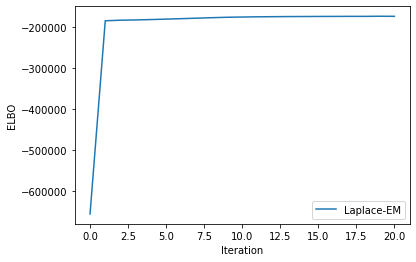

In [10]:
plt.plot(q_lem_elbos, label="Laplace-EM")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

In [299]:
nsamp = 100
T = y.shape[0]

In [300]:
z_s_lem = []
x_s_lem = []
y_s_lem = []
for i in range(nsamp):
    z_i, x_i, y_i = slds_lem.sample(T)
    z_s_lem.append(z_i)
    x_s_lem.append(x_i)
    y_s_lem.append(y_i)

In [301]:
import pickle
pickle.dump([q_lem_elbos, q_lem, slds_lem, [z_s_lem, x_s_lem, y_s_lem], y_train], open(DATA_PATH + f'slds_po_lem_50.pkl', "wb" ) )

In [11]:
# [q_lem_elbos, q_lem, slds_lem, [z_s_lem, x_s_lem, y_s_lem]] = pickle.load(open(DATA_PATH + f'slds_po_lem_50.pkl', "rb" ))

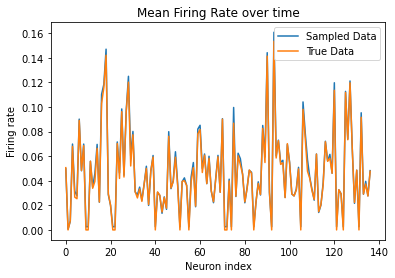

In [302]:
y_s_lem = np.array(y_s_lem)
plt.plot(y_s_lem.mean(axis=0).mean(axis=0), label = 'Sampled Data')
plt.plot(y_train.mean(axis=0), label = 'True Data')
plt.title('Mean Firing Rate over time')
plt.ylabel('Firing rate')
plt.xlabel('Neuron index')
plt.legend(loc='upper right')

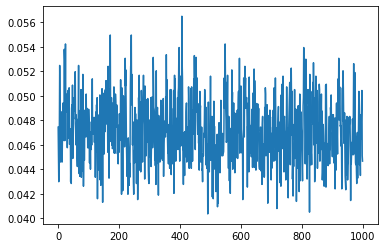

In [303]:
plt.plot(y_s_lem.mean(axis=0).mean(axis=1)[1000:2000])

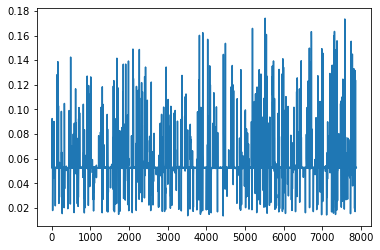

In [304]:
plt.plot(q_lem_y[:,100])

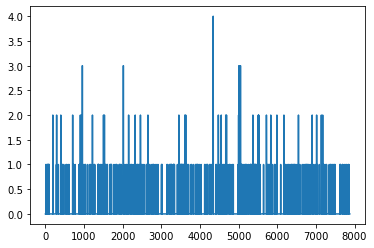

In [305]:
plt.plot(y_train[:,100])

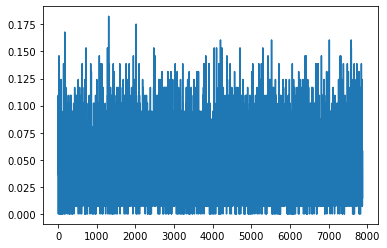

In [306]:
plt.plot(y_train.mean(axis=1))

In [307]:
np.corrcoef(y_train.mean(axis=1), y_s_lem.mean(axis=0).mean(axis=1))

array([[1.        , 0.02981815],
       [0.02981815, 1.        ]])

In [308]:
from statsmodels.nonparametric.smoothers_lowess import lowess
filtered = lowess(y_train.mean(axis=1), list(range(T)), is_sorted=True, frac=0.025, it=0)

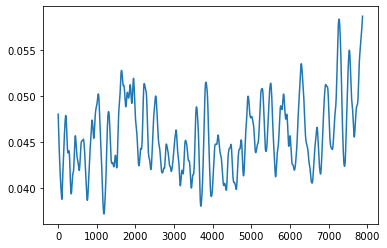

In [309]:
plt.plot(filtered[:,1])

In [310]:
filtered_lem = lowess(y_s_lem.mean(axis=0).mean(axis=1), list(range(y_s_lem.shape[1])), is_sorted=True, frac=0.025, it=0)

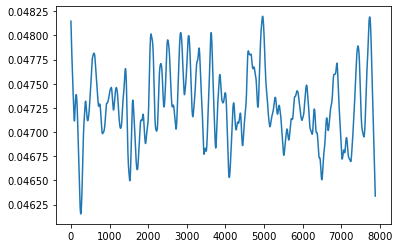

In [311]:
plt.plot(filtered_lem[:,1])

In [312]:
spiketimes = np.where(y_train)[0]
hist = np.histogram(spiketimes,T)[0]/1e-3

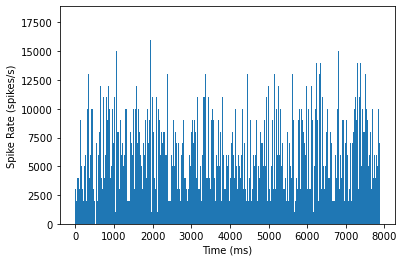

In [313]:
plt.bar(list(range(T)), hist, 2) 
plt.xlabel('Time (ms)')
plt.ylabel('Spike Rate (spikes/s)')
plt.show()

In [76]:
spiketimes_lem = np.where(y_s_lem.mean(axis=0)/137)[0] # need to revisit this
hist_lem = np.histogram(spiketimes_lem,T)[0]/20e-3

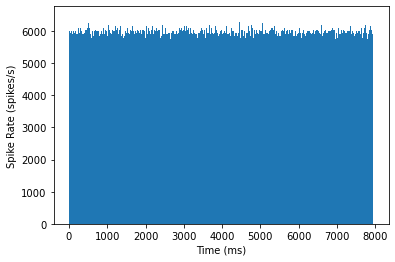

In [71]:
plt.bar(list(range(T)), hist_lem, 2) 
plt.xlabel('Time (ms)')
plt.ylabel('Spike Rate (spikes/s)')
plt.show()

Can do PSTH at coarser level as well

In [106]:
PSTH10 = np.histogram(spiketimes, int(np.floor(T/10)))[0]

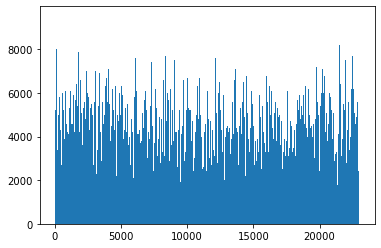

In [107]:
plt.bar(list(range(10,T,10)), PSTH10/10*1000,width=10) #... and plot it.
plt.show()

### TODO: More frequency domain analysis

In [1]:
import scipy.signal as signal

fs = 1
N = T
time = np.arange(N) / fs


f, Pwelch_spec = signal.welch(y[:,3], fs, scaling='spectrum')
plt.semilogy(f, Pwelch_spec)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.grid()
plt.show()

NameError: name 'T' is not defined

In [126]:
from mne.time_frequency import dpss_windows
from numpy.fft import rfft

def mt_specpb(data, Fs=1000, NW=4):
    
    tapers, _ = dpss_windows(data.shape[-1], NW, 2*NW-1) # Compute the tapers,
    tapers *= np.sqrt(Fs)                                   # ... and scale them.
    
    dataT = data * tapers                 
    T = rfft(tapers)                                 # Compute the fft of the tapers.
    J = rfft(dataT)                                  # Compute the fft of the tapered data.
    # Recall that rfft assumes the data are real, and thus 
    J -= T * data            # Subtract the dc (**)
    J *= J.conj()                                        # Compute the spectrum
    S = J.mean(1).real
    f = rfftfreq(data.shape[-1], 1 / Fs)
    return f, S


f, S = mt_specpb(y[:,3])  # Compute the spectrum

plot(f, S)        # Plot the planning period,
xlabel('Freq (Hz)')                     # ... with axes labeled
ylabel('Power (Hz)')
legend()
title('Spectra of spiking data of neuron 4');

ValueError: operands could not be broadcast together with shapes (7,11501) (23001,) 

### Evaluation on test data

  0%|          | 0/50 [00:00<?, ?it/s]

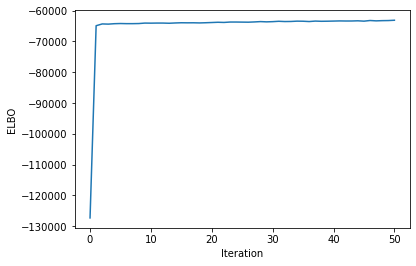

In [314]:
# Compute the approximate posterior over latent and continuous
# states for the new data under the current model parameters.
elbos_test, post_test = slds_lem.approximate_posterior(y_test,
                                              method="laplace_em",
                                              variational_posterior="structured_meanfield",
                                              num_iters=50)

# Verify that the ELBO increases during fitting. We don't expect a substantial increase:
# we are updating the estimate of the latent states but we are not changing model params.
plt.plot(elbos_test)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.show()

In [315]:
test_x = post_test.mean_continuous_states[0]

In [316]:
test_z = slds_lem.most_likely_states(test_x, y_test)

In [317]:
smooth_y_test = slds_lem.smooth(test_x, y_test)

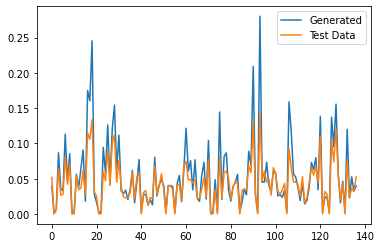

In [318]:
plt.plot(smooth_y_test.mean(axis=0), label='Generated')
plt.plot(y_test.mean(axis=0), label = 'Test Data')
plt.legend(loc='upper right')

State space models:
* Assume: obs are all independent, AFTER conditioning on state
* Assume: future state is independent of past state, AFTER conditioning on present state

Can we look at residuals? Is there a predicted value function? Yes. Here it is the smooth function.

### Residual analysis

In [319]:
y_test.mean()

0.04372906983554015

In [320]:
smooth_y_test.mean()

0.05360946333875773

In [334]:
y_test[:30,0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [335]:
smooth_y_test[:30,0]

array([0.05003409, 0.05394039, 0.03305493, 0.03187368, 0.05130787,
       0.03288167, 0.03178752, 0.05138695, 0.03228793, 0.0333377 ,
       0.03456162, 0.03027931, 0.0510164 , 0.02828308, 0.02887752,
       0.02843177, 0.02941193, 0.02426752, 0.02335243, 0.02498949,
       0.03379803, 0.02996234, 0.02351306, 0.02408617, 0.04068283,
       0.04824383, 0.05340541, 0.05434271, 0.05466451, 0.03192794])

In [321]:
resid = y_test - smooth_y_test

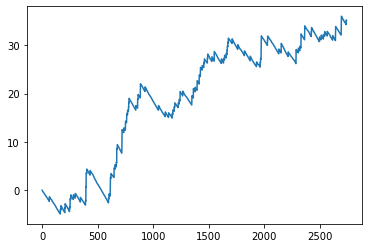

In [322]:
plt.plot(np.cumsum(resid[:,0]))

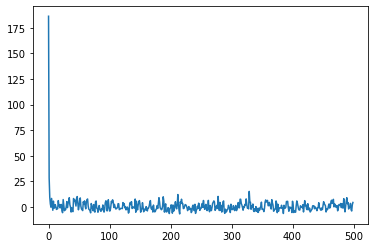

In [348]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):]
plt.plot(autocorr(resid[:,0])[:500])

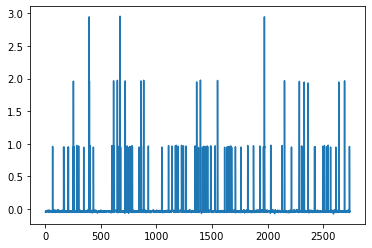

In [349]:
plt.plot(resid[:,0])

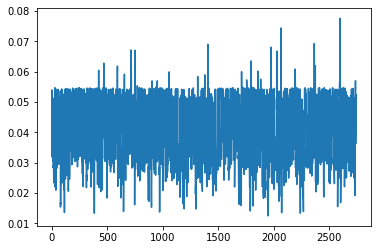

In [330]:
plt.plot(smooth_y_test[:,0])

In [351]:
from statsmodels.stats.stattools import durbin_watson as dw

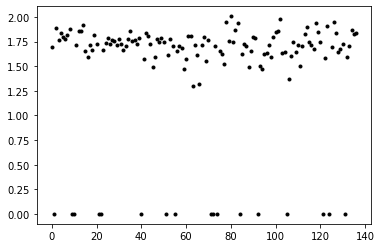

In [357]:
dwtest = dw(resid)
plt.plot(dwtest, '.k')

In [362]:
idx_corr = np.where(dwtest < 0.25)[0]

In [368]:
idx_corr

array([  1,   9,  10,  21,  22,  40,  51,  55,  71,  72,  74,  84,  92,
       105, 121, 124, 131])

In [377]:
y_test[:,idx_corr]

AttributeError: 'numpy.ndarray' object has no attribute 'summary'

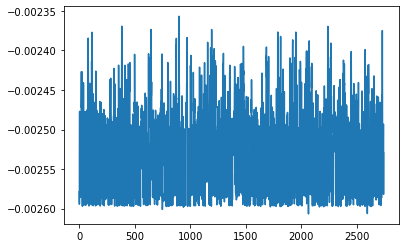

In [367]:
plt.plot(resid[:,idx_corr[3]])

Obviously this is not good - the cumulative residuals should be centered at zero. That means there is some bias that is not being taken care of.

We also see some evidence of correlation - however, we used the Durbin-Watson test to show lack of serial correlation in all but the nonfiring neurons.

Let's also look at the residuals on the training data.

In [165]:
q_lem_y.mean()

0.04645808835156692

In [166]:
y.mean()

0.04561186638731074

In [167]:
resid_train = y - q_lem_y

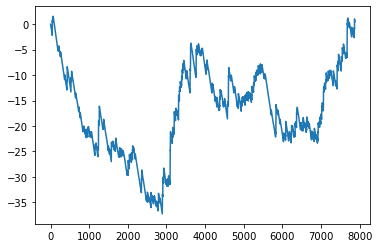

In [188]:
plt.plot(np.cumsum(resid_train[:,0]))

In [184]:
resid_train[:,9]

array([-0.00034894, -0.00034481, -0.00034445, ..., -0.00034959,
       -0.00034959, -0.00034959])

So far we've seen that there does seem to be a bias in the smoothed data from the posterior. There also appears to be some correlation structure, though it seems to be on a relatively low timescale. I would like to see what happens when we train a model with more discrete and continuous states. I also wonder if there's a more principled way of picking the number of discrete/continuous states.

In [263]:
print("Fitting larger SLDS model with Laplace-EM")
K = 15
D = 5
slds_lem2 = ssm.SLDS(N, K, D, emissions="poisson", emission_kwargs=dict(link="softplus"))
slds_lem2.initialize(y)

q_lem_elbos2, q_lem2 = slds_lem2.fit(y, method="laplace_em",
                              variational_posterior="structured_meanfield",
                              num_iters=20, initialize=False, alpha=0)
q_lem_x2 = q_lem2.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
q_lem_z2 = slds_lem2.most_likely_states(q_lem_x2, y)

# Smooth the data under the variational posterior
q_lem_y2 = slds_lem2.smooth(q_lem_x2, y)

Fitting larger SLDS model with Laplace-EM


  0%|          | 0/20 [00:00<?, ?it/s]

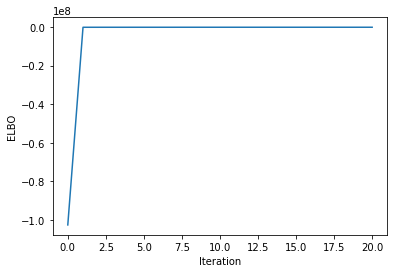

In [264]:
plt.plot(q_lem_elbos2)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.show()

In [265]:
q_lem_elbos2.max()

-160156.89100672034

In [266]:
q_lem_elbos.max()

-175379.73538514168

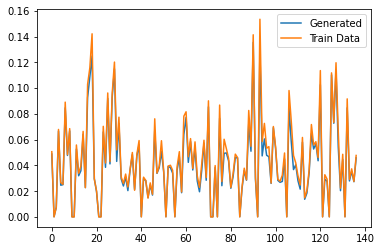

In [267]:
plt.plot(q_lem_y2.mean(axis=0), label='Generated')
plt.plot(y.mean(axis=0), label = 'Train Data')
plt.legend(loc='upper right')

In [268]:
q_lem_y2.mean()

0.04229202656143889

In [269]:
y.mean()

0.04561186638731074

In [270]:
resid2 = y - q_lem_y2

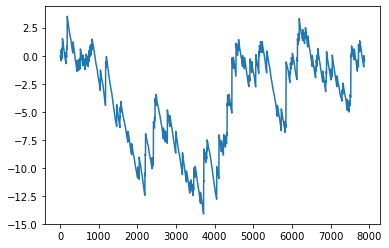

In [287]:
plt.plot(np.cumsum(resid2[:,15]))

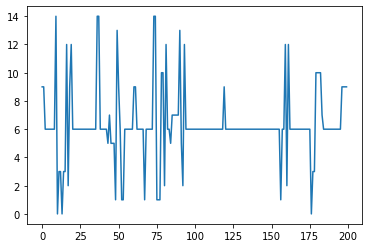

In [230]:
plt.plot(q_lem_z2[400:600])

### Evaluation of states

In [30]:
x_s_lem = np.array(x_s_lem)

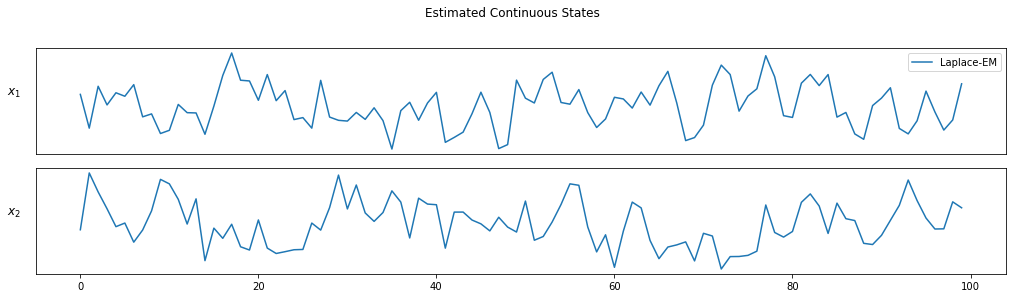

In [32]:
title_str = ["$x_1$", "$x_2$"]
fig, axs = plt.subplots(2,1, figsize=(14,4))
for (d, ax) in enumerate(axs):
    ax.plot(x_s_lem.mean(axis=0)[1000:1100,d] + 4 * d, '-', label="Laplace-EM" if d==0 else None)
    ax.set_yticks([])
    ax.set_title(title_str[d], loc="left", y=0.5, x=-0.03)
axs[0].set_xticks([])
axs[0].legend(loc="upper right")

plt.suptitle("Estimated Continuous States", va="bottom")
plt.tight_layout()

In [42]:
z_s_lem = np.array(z_s_lem)

In [43]:
z_s_lem.shape

(100, 23001)

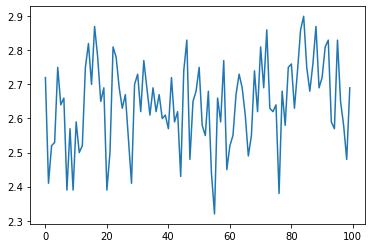

In [45]:
plt.plot(z_s_lem.mean(axis=0)[1000:1100])

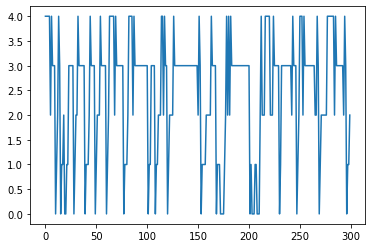

In [49]:
plt.plot(q_lem_z[1000:1300])

## Permutation of states

Given 2 SSMs trained on the same data, it is unlikely they will end up labeling the states in the same way. In fact, beyond just having the same underlying states (x) up to permutation, it is possible that the $x$ states from Model 2 will in fact be linear combinations of the $x$ states from Model 1, and thus not quite able to be permuted. Furthermore, it may be possible that the subspace spanned by the states in Model 1 are not the same as in Model 2. This last assumption is likely the assumption that we need to check first.

In [11]:
print("Fitting SLDS with Laplace-EM")
slds_perm1 = ssm.SLDS(N, K, D, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))
slds_perm1.initialize(y_train)

elbos_perm1, q_perm1 = slds_perm1.fit(y_train, method="laplace_em",
                              variational_posterior="structured_meanfield",
                              num_iters=20, initialize=False, alpha=0)
q_perm1_x = q_perm1.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
q_perm1_z = slds_perm1.most_likely_states(q_perm1_x, y_train)

# Smooth the data under the variational posterior
q_perm1_y = slds_perm1.smooth(q_perm1_x, y_train)

Fitting SLDS with Laplace-EM


  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
print("Fitting SLDS with Laplace-EM")
slds_perm2 = ssm.SLDS(N, K, D, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))
slds_perm2.initialize(y_train)

elbos_perm2, q_perm2 = slds_perm2.fit(y_train, method="laplace_em",
                              variational_posterior="structured_meanfield",
                              num_iters=20, initialize=False, alpha=0)
q_perm2_x = q_perm2.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
q_perm2_z = slds_perm2.most_likely_states(q_perm2_x, y_train)

# Smooth the data under the variational posterior
q_perm2_y = slds_perm2.smooth(q_perm2_x, y_train)

Fitting SLDS with Laplace-EM


  0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
q_perm1_x.shape

(7945, 2)

In [28]:
A2 = slds_perm2.dynamics.As

In [29]:
A1 = slds_perm1.dynamics.As

In [30]:
b1 = slds_perm1.dynamics.bs

In [31]:
b2 = slds_perm2.dynamics.bs

In [31]:
b1

In [44]:
A2

array([[[ 0.04609398, -0.01268963],
        [-0.01526829,  0.09969066]],

       [[ 0.04648146, -0.01271358],
        [-0.01550229,  0.1002998 ]],

       [[ 0.78046616, -0.18523991],
        [-0.37215629,  0.25089305]],

       [[ 0.40473849, -0.06488034],
        [-0.07063639,  0.48930623]],

       [[ 0.54088955, -0.39688112],
        [-0.19577325,  0.52067593]]])

In [49]:
np.linalg.matrix_rank(A2.reshape((10,2)).T)

2

In [50]:
np.linalg.matrix_rank(A1.reshape((10,2)).T)

2

In [54]:
np.linalg.matrix_rank(np.hstack([A2.reshape((10,2)).T, A1.reshape((10,2)).T]))

2

So it appears that these dynamics matrices cover the same subspace, which now is becoming a lot more obvious to me, since the number of rows here is only 2, so obviously they would have rank 2.

In [58]:
transform = np.linalg.lstsq(A2.reshape((10,2)).T, A1.reshape((10,2)).T)

In [60]:
transform[0]

array([[ 4.70744466e-02,  7.59130546e-03,  6.59569450e-03,
         8.28229571e-04,  9.85680738e-03,  2.40973981e-03,
         3.99538095e-02,  1.28762206e-02,  3.67487514e-02,
         9.60019695e-03],
       [ 1.33637399e-01,  4.86275466e-02,  5.41785976e-03,
         2.20310605e-02,  1.69107056e-02,  2.81700433e-02,
         1.18350228e-01,  6.01664862e-02,  4.57001752e-02,
         5.18631002e-02],
       [ 4.75994531e-02,  7.69942640e-03,  6.65772656e-03,
         8.54515736e-04,  9.95714587e-03,  2.45509291e-03,
         4.04036704e-02,  1.30402814e-02,  3.71078110e-02,
         9.72858486e-03],
       [ 1.34249729e-01,  4.88807558e-02,  5.42774679e-03,
         2.21540999e-02,  1.69757622e-02,  2.83230633e-02,
         1.18898043e-01,  6.04686782e-02,  4.58437629e-02,
         5.21283649e-02],
       [ 8.43361270e-01,  1.44401598e-01,  1.14037178e-01,
         2.09431443e-02,  1.73154921e-01,  4.97883014e-02,
         7.17320164e-01,  2.38008747e-01,  6.40185317e-01,
         1.

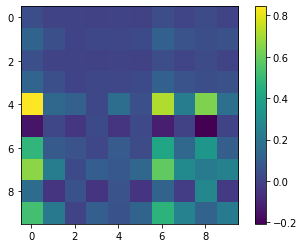

In [65]:
plt.imshow(transform[0])
plt.colorbar()
plt.show()

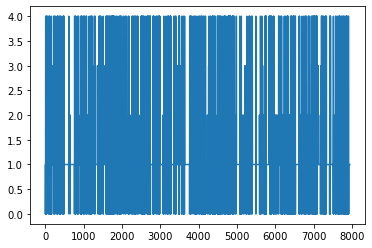

In [67]:
plt.plot(q_perm2_z)

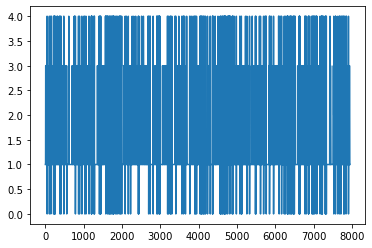

In [68]:
plt.plot(q_perm1_z)

In [69]:
np.corrcoef(q_perm1_z, q_perm2_z)

array([[1.        , 0.63633632],
       [0.63633632, 1.        ]])

In [72]:
from ssm.util import find_permutation, compute_state_overlap
find_permutation(q_perm1_z, q_perm2_z)

array([3, 1, 0, 2, 4])

In [73]:
compute_state_overlap(q_perm1_z, q_perm2_z)

array([[   7.,   25.,   41.,   31.,   38.],
       [ 270., 5613.,   67.,   79.,   83.],
       [  95.,  128.,   13.,   70.,   22.],
       [  35.,  155.,  250.,   56.,  305.],
       [  43.,   43.,   20.,   21.,  435.]])

In [76]:
from matplotlib.colors import ListedColormap
color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = ListedColormap(colors)

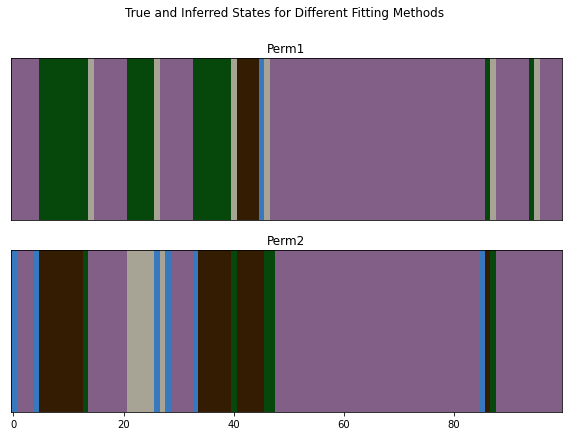

In [78]:
# Plot the true and inferred states
titles = ["Perm1","Perm2"]
states_list = [q_perm1_z[:100], q_perm2_z[:100]]
fig, axs = plt.subplots(len(titles),1, figsize=(8,6))
for (i, ax, states) in zip(range(len(axs)), axs, states_list):
    ax.imshow(states[None,:], aspect="auto", cmap=cmap)
    ax.set_yticks([])
    ax.set_title(titles[i])
    if i < (len(axs) - 1):
        ax.set_xticks([])

plt.suptitle("True and Inferred States for Different Fitting Methods", va="baseline")
plt.tight_layout()

In [94]:
# plt.eventplot for a raster plot, Input is array of spiketimes, not bins

### Priorities now (2/25/2021):

* Script for launching many preemptible GCP instances for running embarrasingly parallel simulations - this is lowest-hanging fruit right now. Don't waste too much time on sims that require message passing right now.
* Zoom out on state overlap - let's examine state overlap at the level of $z$ first. One possible experiment is to run many trials, then check state overlap to determine the modality of the $z$ state landscape - highly clustered overlap would indicate the states are in the same mode, while those with a more homogeneous distribution across rows of overlap would likely indicate they are in a different mode.
* Also - double check Laplace EM. I'm fairly certain it's just a mode-finding algorithm (and I'm pretty certain VI is as well), but probably good to double check, to make sure I don't have this conceptually wrong.
* Current hypothesis is that different modes carry different information in them - ie, some sort of structure not found in the other modes, though I don't have a good way of quantifying this. Some sort of model comparison using test data and prediction possibly. Or residual analysis, though I'm currently not sure how successful that will be.
* Once we clarify what is happening at the level of $z$ states, we can examine what is happening at the level of the $x$ states. For those in the same mode, do they share the same subspace? (Probably). Furthermore - it's possible that those quantified as being in different modes at the $z$ level might actually be in the same mode according to the $x$'s, since $x, z$ from Model 2 might be a linear combination of $x,z$ from Model 1 - thus they are showing the same information, but it looks like it is spread across several $z$ and thus not very clustered.
* There is probably quite a rabbit hole here though, and if it looks promising at this point, it is likely a good idea to get some more theory for (switching) linear dynamical systems, as at least the LDS field is quite mature at this point.
### After determining best ways of state overlap and permutation

* We can get into sequence analysis.
* Especially fruitful at this point will be evaluation of sequences that are from the same data, but different inits and appear to be from different modes and thus are hypothesized to carry different information.
* Furthermore, it will likely be interesting to look at sequences from different models - HMM, LDS, RSLDS, etc. What information do they carry that is different?
* How can we evaluate how robust that information is (and how much of it is due to noise?)
* Once we have found robust sequence(s) for particular data - what do we learn? Can we build any sort of theory based on transition frequencies, length of time in particular states, etc? Motifs? There is a wealth of things to do and examine at this point - look more closely into bioinformatics sequence analysis as well.